# Chris Harrelson's RFC and My Model Analysis

## Import

In [65]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from my_functions import plot_confusion_matrix

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, f1_score, auc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Prepare the data

In [3]:
bigg = pd.read_csv('../data/CJH_big_G.csv', low_memory = False)

In [4]:
bigg['event_time_stamp'] = pd.to_datetime(bigg['event_time_stamp'])

bigg = bigg.loc[(bigg['event_time_stamp'].dt.year > 2014) & (bigg['event_time_stamp'].dt.year <= 2020)]

In [5]:
def create_groups(grp, df):
    df['full_derate'] = False
    df['full_derate'] = (
        np.where(df[f'hours_id_group_{grp}']\
                    .isin(list(df[f'hours_id_group_{grp}']\
                               .loc[(df[f'use_for_first_tow_hours_id_group_{grp}'] == True)])) &
                 (df[f'use_for_first_tow_hours_id_group_{grp}'] == True),
                 True,
                 False)
        )
    
    
    mask = df.loc[(df[f'hours_id_group_{grp}']\
                    .isin(list(df[f'hours_id_group_{grp}']\
                               .loc[(df[f'use_for_first_tow_hours_id_group_{grp}'] == True)]))) &
                    (df[f'use_for_first_tow_hours_id_group_{grp}'] == False)]
    
    row_ls = [i for i in df.index if i not in mask.index]
    
    df = df.loc[row_ls]
    
    grp_col = f'hours_id_group_{grp}'
    
    return df, grp_col

In [6]:
bigg, grp_col = create_groups('14H', bigg)

In [7]:
bigg['common_derate_lamp_status'] = (
    np.where((bigg['lamp_status'] == 22527) | (bigg['lamp_status'] == 18431), True, False)
)

In [8]:
cat_var = ['common_derate_lamp_status',
           'ecu_model',
           'ecu_make',
           'error_category',
           'month']

var = [
    'barometric_pressure',
    'ltd_distance',
    'engine_coolant_temperature',
    'engine_load',
    'engine_oil_pressure',
    'engine_oil_temperature',
    'engine_rpm',
    'ltd_engine_time',
    'fuel_level',
    'ltd_fuel',
    'fuel_rate',
    'intake_manifold_temperature',
    'speed',
    'turbo_boost_pressure',
    'error_duration_(minutes)']

In [9]:
ohe_col_ls = []
for i in cat_var:
    ohe = OneHotEncoder()
    transformed = ohe.fit_transform(bigg[[i]])
    bigg[ohe.get_feature_names_out()] = transformed.toarray()
    ohe_col_ls += [i for i in ohe.get_feature_names_out()]

In [10]:
def log_me(col):
    bigg[col] = (
        np.where((bigg[col].notnull()) & 
                 (np.log(bigg[col]) != -np.inf) &
                 (np.log(bigg[col]) != np.inf), 
                 np.log(bigg[col]), np.nan)
    )
    
    return bigg[col]

log_cols = ['engine_oil_temperature',
            'ltd_engine_time',
            'fuel_rate',
            'turbo_boost_pressure',
            'speed',
            'error_duration_(minutes)']

bigg['barometric_pressure'] = np.exp(bigg['barometric_pressure'])

In [11]:
cat_vars = bigg.groupby(grp_col)[ohe_col_ls].sum().reset_index()

In [12]:
mean_vars = bigg.groupby(grp_col)[var].mean().reset_index().fillna(0)
std_vars = bigg.groupby(grp_col)[var].std().reset_index().fillna(0)

In [13]:
target_values = bigg[[grp_col, 'full_derate']].drop_duplicates()

In [14]:
all_vars = pd.merge(mean_vars, std_vars, on = grp_col).merge(cat_vars, on = grp_col)

## Train the model

In [15]:
X = all_vars.drop(columns = grp_col)
y = target_values['full_derate']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.20, 
                                                    train_size = 0.80, 
                                                    random_state = 100, 
                                                    stratify = y)

In [16]:
pipe = Pipeline(
    steps = [
        ('smt', SMOTE(n_jobs = -1)),
        ('scale', StandardScaler()),
        ('rf', RandomForestClassifier()) 
    ]
)


cv = cross_val_score(estimator = pipe,
                     X = X_train,
                     y = y_train, 
                     cv = 5,
                     n_jobs = -1,
                     scoring = 'precision', 
                     verbose = 2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.9min remaining:  7.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.0min finished


In [17]:
cv

array([0.71111111, 0.44736842, 0.47619048, 0.46153846, 0.50847458])

In [18]:
cv = cross_val_score(estimator = pipe,
                     X = X_train,
                     y = y_train, 
                     cv = 5,
                     n_jobs = -1,
                     scoring = 'recall', 
                     verbose = 2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.4min remaining:  6.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.4min finished


In [19]:
cv

array([0.26363636, 0.31192661, 0.27272727, 0.30909091, 0.3       ])

In [20]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('smt', SMOTE(n_jobs=-1)), ('scale', StandardScaler()),
                ('rf', RandomForestClassifier())])

In [21]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     41685
        True       0.62      0.40      0.49       137

    accuracy                           1.00     41822
   macro avg       0.81      0.70      0.74     41822
weighted avg       1.00      1.00      1.00     41822



In [22]:
print(confusion_matrix(y_test, pipe.predict(X_test)))

[[41652    33]
 [   82    55]]


## Analyze the model

### Create functions

In [23]:
def cost_scorer(y_test, y_pred, cost_fp = 500, cost_fn = 5000):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (cost_fp*fp) + (cost_fn*fn)

In [24]:
def savings_scorer(y_test, y_pred, save_tp = 5000, cost_fp = -500):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (save_tp*tp) + (cost_fp*fp)

In [25]:
def plotly_roc(y_true, y_pred_probs):

    fpr, tpr, thresholds = roc_curve(y_true, [p[1] for p in y_pred_probs])
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("The optimum tpr vs. fpr threshold value is:", optimal_threshold)

    fig = px.area(
        x=fpr, 
        y=tpr,
        hover_data=[thresholds],
        title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
        labels=dict(x='False Positive Rate', 
                    y='True Positive Rate',
                    hover_data_0 = 'Threshold'),
        width=700, 
        height=500
    )

    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1
    )

    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    fig.update_xaxes(constrain='domain')
    return fig

In [26]:
def plot_costs_by_threshold(costs_df, multiwindow = False):

    min_costs = costs_df.nsmallest(1, 'total_costs')['total_costs'].values[0]
    cheapest_threshold = costs_df.nsmallest(1, 'total_costs')['threshold'].values[0]

    if multiwindow:
        cheapest_window = costs_df.nsmallest(1, 'total_costs')['target_window'].values[0]
        fig = px.line(costs_df,
            x = 'threshold',
            y = 'total_costs',
            color='target_window',
            width = 700,
            height = 500,
            title=f'Minimum Total Costs are ${min_costs:,.2f}<br>with a Target Window of {cheapest_window}<br>and a Threshold of {cheapest_threshold}'
        )
    else:
        fig = px.line(costs_df,
            x = 'threshold',
            y = 'total_costs',
            width = 700,
            height = 500,
            title=f'Minimum Total Costs are ${min_costs:,.2f}<br>with a Threshold of {cheapest_threshold}'
        )
    return fig

In [27]:
def plot_savings_by_threshold(savings_df, multiwindow = False):

    max_savings = savings_df.nlargest(1, 'total_savings')['total_savings'].values[0]
    best_threshold = savings_df.nlargest(1, 'total_savings')['threshold'].values[0]

    if multiwindow:
        best_window = savings_df.nlargest(1, 'total_savings')['target_window'].values[0]
        fig = px.line(savings_df,
            x = 'threshold',
            y = 'total_savings',
            color='target_window',
            width = 700,
            height = 500,
            title=f'Maximum Total Savings are ${max_savings:,.2f}<br>with a Target Window of {best_window}<br>and a Threshold of {best_threshold}'
        )
    else:
        fig = px.line(savings_df,
            x = 'threshold',
            y = 'total_savings',
            width = 700,
            height = 500,
            title=f'Maximum Total Savings are ${max_savings:,.2f}<br>with a Threshold of {best_threshold}'
        )
    return fig

In [28]:
def quick_report(y_true, y_pred_probs, threshold, cost_fp=500, cost_fn=5000):
    preds = [p[1] > threshold for p in y_pred_probs]
    tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()
    print("confusion matrix:\n", confusion_matrix(y_true, preds))
    print("False Positives: ", fp, "\nFalse Negatives: ", fn)
    print("f1 score: ", f1_score(y_true, preds))
    print("Total Cost: ",  "${:,.2f}".format(cost_scorer(y_true, preds, cost_fp=cost_fp, cost_fn=cost_fn)))
    return

### Model analysis on training data

In [51]:
y_preds = pipe.predict(X_train)
y_probs = pipe.predict_proba(X_train)

In [30]:
threshold_range = np.concatenate([np.arange(0.001, 0.01, 0.001), np.arange(0.01, 0.1, 0.01), np.arange(0.1, 1, 0.1), np.arange(0.9, 1, 0.01), np.arange(0.99, 0.9985, 0.001), np.arange(0.999, 1.0001, 0.0001)])
savings_dict = {t: {'total_savings': savings_scorer(y_train, [p[1] > t for p in y_probs]), 'f1_score': f1_score(y_train, [p[1] > t for p in y_probs])} for t in threshold_range}
savings_df = (pd.concat({k: pd.DataFrame.from_dict(v, orient='index') for k, v in savings_dict.items()}, axis=0)
                        .unstack(level = 1)
    )
savings_df.index = savings_df.index.rename('threshold')
savings_df.columns = savings_df.columns.droplevel(level=0)
savings_df = savings_df.reset_index()

In [31]:
threshold_range = np.concatenate([np.arange(0.001, 0.01, 0.001), np.arange(0.01, 0.1, 0.01), np.arange(0.1, 1, 0.1), np.arange(0.9, 1, 0.01), np.arange(0.99, 0.9985, 0.001), np.arange(0.999, 1.0001, 0.0001)])
costs_dict = {t: {'total_costs': cost_scorer(y_train, [p[1] > t for p in y_probs], cost_fp=500, cost_fn=5000), 'f1_score': f1_score(y_train, [p[1] > t for p in y_probs])} for t in threshold_range}
costs_df = (pd.concat({k: pd.DataFrame.from_dict(v, orient='index') for k, v in costs_dict.items()}, axis=0)
                        .unstack(level = 1)
    )
costs_df.index = costs_df.index.rename('threshold')
costs_df.columns = costs_df.columns.droplevel(level=0)
costs_df = costs_df.reset_index()

In [32]:
plot_costs_by_threshold(costs_df)

In [33]:
plot_savings_by_threshold(savings_df)

In [34]:
quick_report(y_train, y_probs, threshold=0.4)

confusion matrix:
 [[166735      2]
 [     2    547]]
False Positives:  2 
False Negatives:  2
f1 score:  0.9963570127504554
Total Cost:  $11,000.00


In [35]:
quick_report(y_train, y_probs, threshold=0.2)

confusion matrix:
 [[166604    133]
 [     0    549]]
False Positives:  133 
False Negatives:  0
f1 score:  0.8919577579203899
Total Cost:  $66,500.00


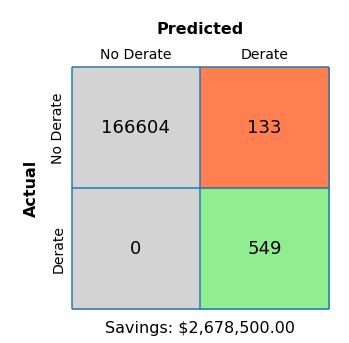

In [67]:
plot_confusion_matrix(y_train, [p[1] > 0.2 for p in y_probs], labels = ['No Derate', 'Derate'], metric = 'savings')

### Model analysis on test data

In [70]:
y_preds = pipe.predict(X_test)
y_probs = pipe.predict_proba(X_test)

In [38]:
fig_roc = plotly_roc(y_test, y_probs)

The optimum tpr vs. fpr threshold value is: 0.04


In [39]:
threshold_range = np.concatenate([np.arange(0.001, 0.01, 0.001), np.arange(0.01, 0.1, 0.01), np.arange(0.1, 1, 0.1), np.arange(0.9, 1, 0.01), np.arange(0.99, 0.9985, 0.001), np.arange(0.999, 1.0001, 0.0001)])
savings_dict = {t: {'total_savings': savings_scorer(y_test, [p[1] > t for p in y_probs]), 'f1_score': f1_score(y_test, [p[1] > t for p in y_probs])} for t in threshold_range}
savings_df = (pd.concat({k: pd.DataFrame.from_dict(v, orient='index') for k, v in savings_dict.items()}, axis=0)
                        .unstack(level = 1)
    )
savings_df.index = savings_df.index.rename('threshold')
savings_df.columns = savings_df.columns.droplevel(level=0)
savings_df = savings_df.reset_index()

In [40]:
threshold_range = np.concatenate([np.arange(0.001, 0.01, 0.001), np.arange(0.01, 0.1, 0.01), np.arange(0.1, 1, 0.1), np.arange(0.9, 1, 0.01), np.arange(0.99, 0.9985, 0.001), np.arange(0.999, 1.0001, 0.0001)])
costs_dict = {t: {'total_costs': cost_scorer(y_test, [p[1] > t for p in y_probs], cost_fp=500, cost_fn=5000), 'f1_score': f1_score(y_test, [p[1] > t for p in y_probs])} for t in threshold_range}
costs_df = (pd.concat({k: pd.DataFrame.from_dict(v, orient='index') for k, v in costs_dict.items()}, axis=0)
                        .unstack(level = 1)
    )
costs_df.index = costs_df.index.rename('threshold')
costs_df.columns = costs_df.columns.droplevel(level=0)
costs_df = costs_df.reset_index()

In [41]:
plot_costs_by_threshold(costs_df)

In [42]:
quick_report(y_test, y_probs, threshold=0.2)

confusion matrix:
 [[41372   313]
 [   34   103]]
False Positives:  313 
False Negatives:  34
f1 score:  0.3725135623869801
Total Cost:  $326,500.00


In [43]:
import chart_studio
import json
import chart_studio.plotly as py
import chart_studio.tools as tls

username = 'jrioross'
api_key = json.load(open('../data/api_keys.json'))['chart_studio']

chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

In [44]:
fig_sav = plot_savings_by_threshold(savings_df)
fig_sav.show()

In [45]:
py.plot(fig_sav, filename = 'rfc_savings', auto_open=True)

'https://plotly.com/~jrioross/1/'

In [46]:
tls.get_embed('https://plotly.com/~jrioross/1/')

'<iframe id="igraph" scrolling="no" style="border:none;" seamless="seamless" src="https://plotly.com/~jrioross/1.embed" height="525" width="100%"></iframe>'

In [47]:
py.plot(fig_roc, filename = 'rfc_roc', auto_open=True)

'https://plotly.com/~jrioross/3/'

In [48]:
tls.get_embed('https://plotly.com/~jrioross/3/')

'<iframe id="igraph" scrolling="no" style="border:none;" seamless="seamless" src="https://plotly.com/~jrioross/3.embed" height="525" width="100%"></iframe>'

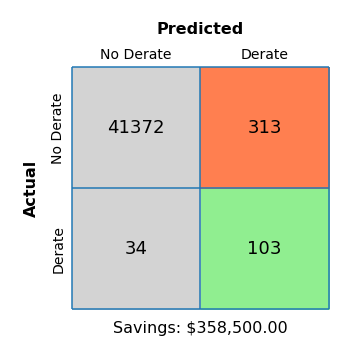

In [71]:
fig_cm = plot_confusion_matrix(y_test, [p[1] > 0.2 for p in y_probs], labels = ['No Derate', 'Derate'], metric = 'savings')
plt.savefig('../data/fig_cm.png')